# Description
Open scraped json data and do EDA
# Imports

In [1]:
import json
import re
from pandas.io.json import json_normalize
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters

In [2]:
alt.renderers.enable(embed_options={'theme': 'vox'})

RendererRegistry.enable('default')

In [3]:
data_path = r'../../data/ots_snowfall_data.json'

# Load Data

In [4]:
with open(data_path, 'r') as json_file:
    json_file_read = json_file.read()
    json_file_clean = json.loads(json_file_read)
    raw_df = pd.DataFrame(json_file_clean)
raw_df.tail()

,station,what_data,year,url,data
5431,Bruce Mound,base,2018,https://www.onthesnow.com/wisconsin/bruce-moun...,"{'Dec 2018': {'15': 12, '16': 12, '17': 12, '1..."
5432,Sleeping Giant,base,2018,https://www.onthesnow.com/wyoming/sleeping-gia...,"{'Dec 2018': {'14': 30, '15': 28, '16': 26, '1..."
5433,Elko SnoBowl,base,2018,https://www.onthesnow.com/nevada/elko-snobowl/...,{}
5434,Eagle Point,base,2018,https://www.onthesnow.com/utah/eagle-point/his...,"{'Dec 2018': {'28': 28, '29': 28, '30': 28, '3..."
5435,Pine Knob,base,2018,https://www.onthesnow.com/michigan/pine-knob-s...,"{'Nov 2018': {'30': 24}, 'Dec 2018': {'1': 24,..."


In [125]:
def data_exploder(df, station):
    """create dataframe of station data in tabular form
    todo: make more efficient for loading all data at once"""

    def cleaner(df, data_pt):
        """pull data out of json into columns"""
        return (pd.json_normalize(df.loc[df.what_data == data_pt, 'data'])
                .sum()
                .T.to_frame()
                .rename(columns={0: data_pt}))

    station_df = (df.query('station == @station')[['data', 'what_data', 'url']])
    state_rx = r"(?<=^[https:\/\/www.onthesnow.com\/])(\w*)(?=\/)"
    state = re.search(station_df.head(1).url.values[0], string=state_rx)
    print(state)
    base_df = cleaner(station_df, 'base')
    snowfall_df = cleaner(station_df, 'snowfall')
    station_data = pd.concat([base_df, snowfall_df], axis=1)
    station_data['station'] = station
    station_data['state'] = state
    dt_format = "%b %Y.%d"
    station_data.index = pd.to_datetime(station_data.index, format=dt_format)
    return station_data

In [74]:
def annualizer(df):
    """grounds and aggregates by day of year"""
    df.index.name = 'timestamp'

    def day_standardizer(day):
        """moves start of year forward so ski season isn't split"""
        rewind = 130  # days before 12/31 to start ski season
        return np.mod((day+rewind), 366)
    df_by_yr = (df
                .reset_index()
                .assign(year=lambda x: x.timestamp.dt.year)
                .assign(month=lambda x: x.timestamp.dt.month)
                .assign(day=lambda x: x.timestamp.dt.day)
                .assign(dayofyr=lambda x: 
                        day_standardizer(x.timestamp.dt.dayofyear))
                .assign(ski_yr=lambda x: (x.dayofyr/365 + (x.year - 2010)).astype('int'))
                .reset_index()
                .filter(['dayofyr', 'timestamp', 'base', 
                         'station', 'snowfall', 'ski_yr'])
                )
    return df_by_yr

In [7]:
all_data_df = pd.concat([data_exploder(raw_df, x) for x in raw_df.station.unique()])
all_data_full_df = all_data_df.pipe(annualizer)

(284909, 3)

In [54]:
# Pandas Groupby multiple items ALWAYS resets index to multiindex. UGH.
last_days_tmp = (all_data_full_df
                 .groupby(['station', 'ski_yr'], as_index=False)
                 [['dayofyr']]
                 .idxmax()
                 .rename(columns={'dayofyr': 'index_'})  # srly wtf. index grabbed aggregated col name
                )

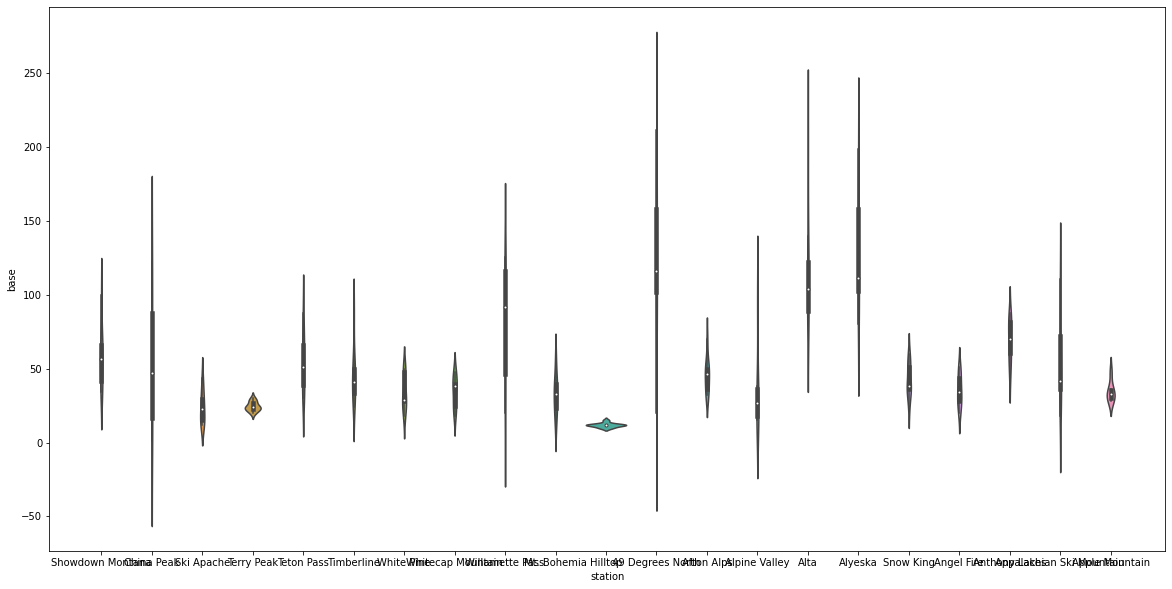

In [69]:
last_days_df = (all_data_full_df
                .merge(right=last_days_tmp, 
                       left_index=True,
                       right_on='index_')
                .loc[:, ['dayofyr', 'timestamp', 'base', 'snowfall']]
               )
plt.figure(figsize=(20,10))
last_days_base_viz = sns.violinplot(data=last_days_df.reset_index(col_level=1).iloc[0:200,:],
                                    x='station', y='base')
last_days_base_viz.plot();

### test data load

In [10]:
raw_df.pipe(data_exploder, 'Kirkwood').pipe(annualizer).query('timestamp=="2014-01-01"')

,dayofyr,timestamp,base,station,snowfall,ski_yr
370,101,2014-01-01,18.0,Kirkwood,NaN,4


# Explore Data with Viz

In [11]:
def base_plotter(name=None, df=raw_df):
    station_data = (df
                    .pipe(data_exploder, name)
                    .pipe(annualizer))
    base_chart = (alt.Chart(station_data)
              .mark_line().encode(x='dayofyr:Q',
                                  y=alt.Y('base:Q', 
                                          aggregate='mean',
                                         ),
                                  #color='year:T',
                                  tooltip=['base_mean:Q']
                                  )
              .properties(title=alt.TitleParams(
                    text=[f'Snow Base Average at {name}'],
                    subtitle=['starts from begining of ski season']  ))
              )
    band = (alt.Chart(station_data)
            .mark_errorband(extent='ci')
            .encode(x='dayofyr:Q', 
                    y='base:Q',)
           )

    combined_chart = base_chart + band

    combined_chart.display()
    return combined_chart
_ = base_plotter('Arapahoe Basin')

alt.LayerChart(...)

# Timeseries Modeling
## ARIMA and extensions

### Modeling regions as single series
Concat all base ts from a region into single long series

In [70]:
region_map = {'East': ['New_York', 'Vermont', 'Pennsylvania', 'West_Virginia'],
              'Colorado': ['Colorado'],
              'Utah': ['Utah'],
              'Sierras': ['California', 'Nevada'],
              'Cascades': ['Washington', 'Oregon', 'British_Columbia'],
              'Other': ['Alabama', 'Alaska', 'Alberta', 'Arizona',
                        'Connecticut', 'Idaho', 'Illinois',
                        'Indiana', 'Iowa', 'Maine', 'Maryland', 
                        'Massachusetts',
                        'Michigan', 'Minnesota', 'Missouri', 'Montana',
                        'New Hampshire', 'New Jersey', 'New Mexico',
                        'Newfoundland_and_Labrador', 'North_Carolina', 
                        'North_Dakota', 'Nova Scotia', 'Ohio', 'Ontario',
                        'Quebec', 'Rhode_Island', 'South_Dakota', 'Tennessee',
                        'Virginia', 'Wisconsin',
                        'Wyoming']
              }
region_reverse_map = {}
for region, states in region_map.items():
    for state in states:
        region_reverse_map.update({state: region})

In [72]:
all_data_full_df.head()

,dayofyr,timestamp,base,station,snowfall,ski_yr
0,100,2010-12-02,36.0,Showdown Montana,NaN,0
1,101,2010-12-03,36.0,Showdown Montana,NaN,0
2,102,2010-12-04,38.0,Showdown Montana,6.0,0
3,103,2010-12-05,38.0,Showdown Montana,NaN,0
4,105,2010-12-07,42.0,Showdown Montana,NaN,0


In [ ]:
long_series_df = (all_data_full_df
                 .)

In [12]:
pd.plotting.autocorrelation_plot(df["R"].resample("1y").median())

NameError: name 'df' is not defined

ARIMAX using snowfall data with powder -> packed powder and melt inference

#### Other models
GARCH, Gaussian Process, hidden Markov

### Panel Models

# TF LSTM models